### 1-1. 데이터 로드

In [1]:
import FinanceDataReader as fdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, Normalizer

WINDOW_SIZE = 20 # 이전 20일간의 데이터를 이용하여 다음날의 Close 예측

In [2]:
df = fdr.DataReader('ETH/KRW', '2017-11-11', '2023-02-07') # 빗썸기준
df.tail() # 시가, 고가, 저가, 종가, 조정 종가, 거래량

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-02-02,2006200.625,2084810.250,2003982.250,2013381.750,2013381.750,12936288829592
2023-02-03,2012969.000,2078767.500,2007286.500,2077352.750,2077352.750,10194335288017
2023-02-04,2077011.750,2109007.750,2056692.875,2080239.875,2080239.875,7291565039205
2023-02-05,2080373.625,2086118.500,2017014.500,2036055.625,2036055.625,8643504898765
2023-02-06,2036054.875,2085601.625,2032647.000,2038984.625,2038984.625,8729798977234


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1914 entries, 2017-11-11 to 2023-02-06
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1914 non-null   float64
 1   High       1914 non-null   float64
 2   Low        1914 non-null   float64
 3   Close      1914 non-null   float64
 4   Adj Close  1914 non-null   float64
 5   Volume     1914 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 104.7 KB


### 1-2. 데이터 전처리

In [4]:
## 데이터 정규화 (0 ~ 1의 사이값으로 조정)
df.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Volume', 'Close']
df_scaled = scaler.fit_transform(df[scale_cols])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

df_scaled = df_scaled.to_numpy()
X = df_scaled[:,:-1] # Open, High, Low, Volume
y = df_scaled[:,-1] # Close
print(X.shape, y.shape)

(1914, 4) (1914,)


### 1-3. 시계열 데이터의 데이터셋 분리

In [5]:
data_X, data_y = [], []
for i in range(len(y) - WINDOW_SIZE):
    _X = X[i: i + WINDOW_SIZE]
    _y = y[i + WINDOW_SIZE]
    data_X.append(_X)
    data_y.append(_y)
data_X = np.array(data_X)
data_y = np.array(data_y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.3, shuffle=False) # 시계열 데이터 이기 대문에 shuffle=False
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1325, 20, 4) (1325,)
(569, 20, 4) (569,)


### 1-4. 모델 학습

In [7]:
model = Sequential(name = 'eth')
model.add(LSTM(20, input_shape=(WINDOW_SIZE, len(data_X[0][0])), activation='relu', return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1))

model.summary()

Model: "eth"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                2000      
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 2,021
Trainable params: 2,021
Non-trainable params: 0
_________________________________________________________________


In [8]:
## 컴파일
model.compile(loss='mse', optimizer='adam', metrics='acc')

In [9]:
model_path = './model/eth-{epoch:2d}-{val_loss:.4f}.hdf5'
checkpoint = ModelCheckpoint(filepath=model_path, verbose=1, save_best_only=True)
earlystop = EarlyStopping(patience=10)
history = model.fit(X_train, y_train, epochs=200, batch_size=10, validation_split=0.3, callbacks=[checkpoint, earlystop])

Epoch 1/200
80/93 [========================>.....] - ETA: 0s - loss: 8.5007e-04 - acc: 0.0012
Epoch 1: val_loss improved from inf to 0.00266, saving model to ./model\eth- 1-0.0027.hdf5
93/93 [==============================] - 2s 8ms/step - loss: 7.9751e-04 - acc: 0.0011 - val_loss: 0.0027 - val_acc: 0.0000e+00
Epoch 2/200
92/93 [============================>.] - ETA: 0s - loss: 3.5982e-04 - acc: 0.0011    
Epoch 2: val_loss did not improve from 0.00266
93/93 [==============================] - 0s 4ms/step - loss: 3.5753e-04 - acc: 0.0011 - val_loss: 0.0060 - val_acc: 0.0000e+00
Epoch 3/200
88/93 [===========================>..] - ETA: 0s - loss: 3.2364e-04 - acc: 0.0011
Epoch 3: val_loss did not improve from 0.00266
93/93 [==============================] - 0s 5ms/step - loss: 3.1325e-04 - acc: 0.0011 - val_loss: 0.0036 - val_acc: 0.0000e+00
Epoch 4/200
92/93 [============================>.] - ETA: 0s - loss: 2.0613e-04 - acc: 0.0011 
Epoch 4: val_loss did not improve from 0.00266
93/93 

In [10]:
model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 0.0084 - acc: 0.0018


[0.0083567313849926, 0.0017574692610651255]

18/18 [==============================] - 0s 2ms/step


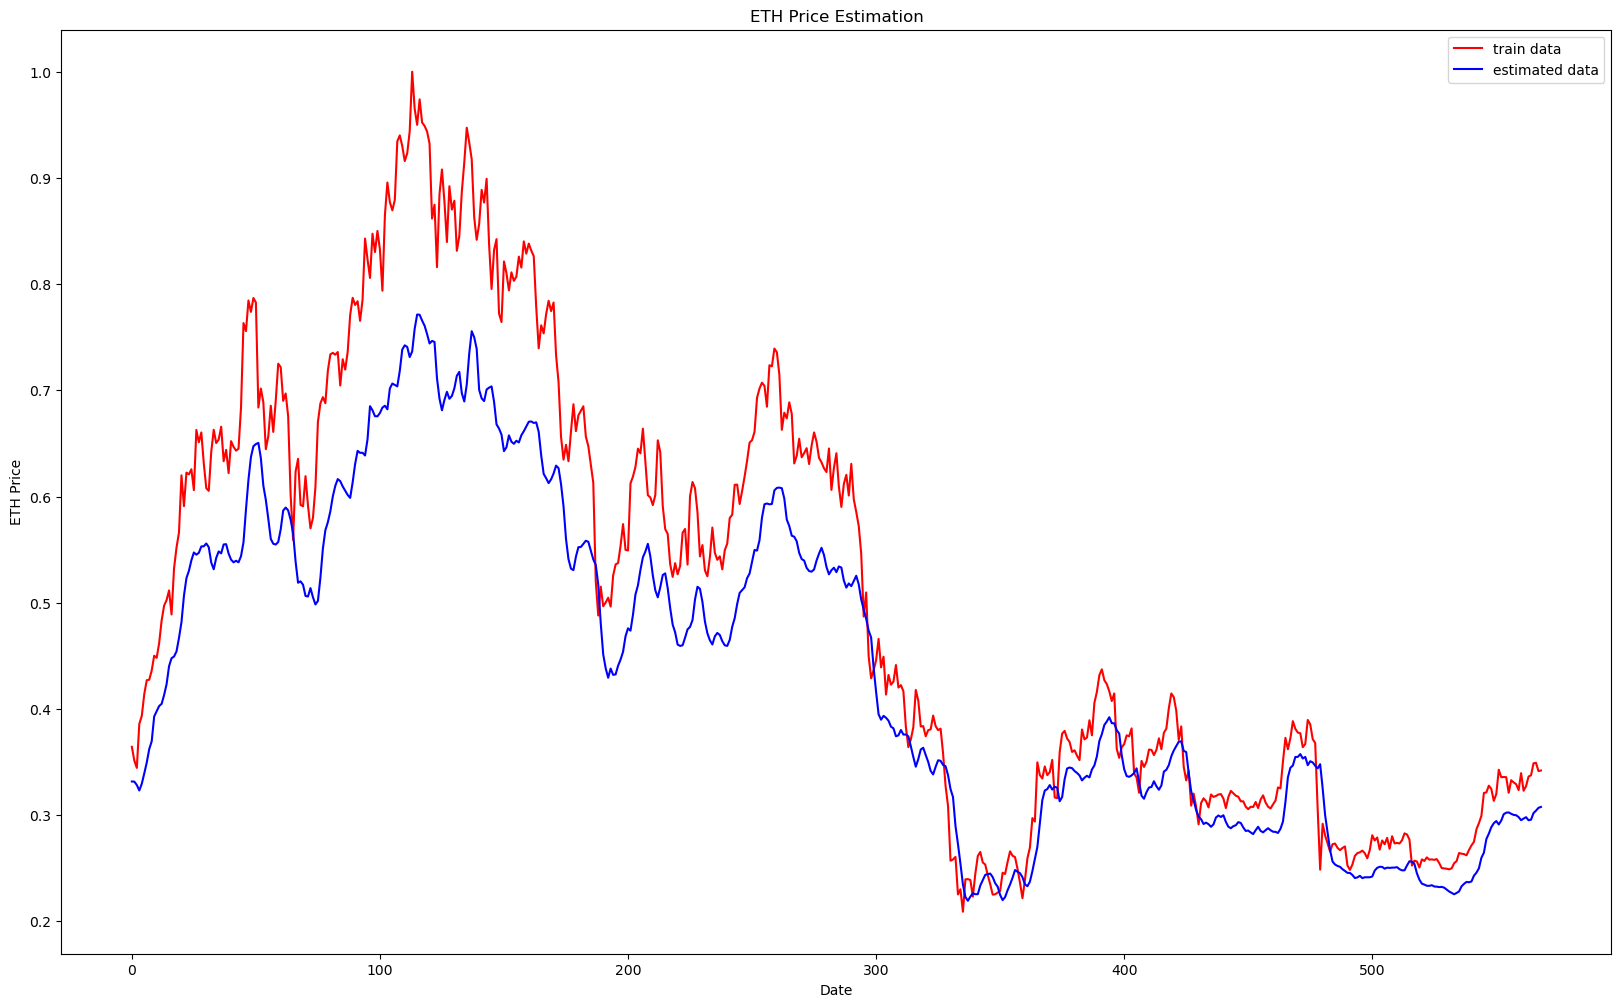

In [11]:
y_pred = model.predict(X_test)
plt.figure(figsize=(20,12))
plt.plot(y_test, color='red', label='train data')
plt.plot(y_pred, color='blue', label='estimated data')
plt.title('ETH Price Estimation')
plt.xlabel('Date')
plt.ylabel('ETH Price')
plt.legend()
plt.show()

In [12]:
last_estimated_price = (df.Close[-1] * y_pred[-1]) / y[-1]
last_real_price = df.Close[-1]
a = last_estimated_price - last_real_price
print("2023-02-06 예상 ETH 가격 :", last_estimated_price, 'KRW')
print("2023-02-06 실제 ETH 가격 :", last_real_price, 'KRW')
print("차이 : ", a)

2023-02-06 예상 ETH 가격 : [1834528.1] KRW
2023-02-06 실제 ETH 가격 : 2038984.625 KRW
차이 :  [-204456.5]


### 2. 차이가 있어 보이니까 특성들(미국 3대 지수)을 추가해보기로 함

In [13]:
# 미국 3대 지수 추가. DJI(다우존스), IXIC(나스닥), US500(S&P 500)
df_DJI = fdr.DataReader('DJI', '2017-11-11', '2023-02-07')
df_DJI.rename(columns={'Close':'DJI'}, inplace=True)
df_DJI = df_DJI.DJI

df_IXIC = fdr.DataReader('IXIC', '2017-11-11', '2023-02-07')
df_IXIC.rename(columns={'Close':'IXIC'}, inplace=True)
df_IXIC = df_IXIC.IXIC

df_US500 = fdr.DataReader('US500', '2017-11-11', '2023-02-07')
df_US500.rename(columns={'Close':'US500'}, inplace=True)
df_US500 = df_US500.US500


In [14]:
# 총 데이터 개수가 1316개임. 주말 데이터가 없다!!
print(len(df_DJI), len(df_IXIC), len(df_US500))

1316 1316 1316


In [15]:
df_dns = pd.merge(df, df_DJI, how='outer', on='Date')
df_dns = pd.merge(df_dns, df_IXIC, how='outer', on='Date')
df_dns = pd.merge(df_dns, df_US500, how='outer', on='Date')

In [16]:
# 주말 데이터가 없으므로(널값) 이전 데이터로 먼저 채워주고, 없으면 뒤에꺼로 채워주기
df_dns.fillna(method='ffill', inplace=True)
df_dns.fillna(method='bfill', inplace=True)

In [17]:
df_dns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1914 entries, 2017-11-11 to 2023-02-06
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1914 non-null   float64
 1   High       1914 non-null   float64
 2   Low        1914 non-null   float64
 3   Close      1914 non-null   float64
 4   Adj Close  1914 non-null   float64
 5   Volume     1914 non-null   int64  
 6   DJI        1914 non-null   float64
 7   IXIC       1914 non-null   float64
 8   US500      1914 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 149.5 KB


### 2-1. 데이터 스케일링부터 다시

In [18]:
## 데이터 정규화 (0 ~ 1의 사이값으로 조정)
df_dns.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Volume', 'DJI', 'IXIC', 'US500','Close']
df_dns_scaled = scaler.fit_transform(df_dns[scale_cols])
df_scaled = pd.DataFrame(df_dns_scaled)
df_scaled.columns = scale_cols

df_scaled = df_scaled.to_numpy()
X = df_scaled[:,:-1] # Open, High, Low, Volume
y = df_scaled[:,-1] # Close

data_X, data_y = [], []
for i in range(len(y) - WINDOW_SIZE):
    _X = X[i: i + WINDOW_SIZE]
    _y = y[i + WINDOW_SIZE]
    data_X.append(_X)
    data_y.append(_y)
data_X = np.array(data_X)
data_y = np.array(data_y)

X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.3, shuffle=False) # 시계열 데이터 이기 대문에 shuffle=False
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1325, 20, 7) (1325,)
(569, 20, 7) (569,)


### 2-3. 모델 학습

In [19]:
model = Sequential(name = 'eth_dns')
model.add(LSTM(20, input_shape=(WINDOW_SIZE, len(data_X[0][0])), activation='relu', return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1))

model.summary()

Model: "eth_dns"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 20)                2240      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,261
Trainable params: 2,261
Non-trainable params: 0
_________________________________________________________________


In [20]:
## 컴파일
model.compile(loss='mse', optimizer='adam', metrics='acc')

In [21]:
model_path = './model/eth_dns-{epoch:2d}-{val_loss:.4f}.hdf5'
checkpoint = ModelCheckpoint(filepath=model_path, verbose=1, save_best_only=True)
earlystop = EarlyStopping(patience=10)
history = model.fit(X_train, y_train, epochs=200, batch_size=10, validation_split=0.3, callbacks=[checkpoint, earlystop])

Epoch 1/200
92/93 [============================>.] - ETA: 0s - loss: 0.0025 - acc: 0.0011
Epoch 1: val_loss improved from inf to 0.01874, saving model to ./model\eth_dns- 1-0.0187.hdf5
93/93 [==============================] - 2s 11ms/step - loss: 0.0025 - acc: 0.0011 - val_loss: 0.0187 - val_acc: 0.0000e+00
Epoch 2/200
84/93 [==========================>...] - ETA: 0s - loss: 5.9277e-04 - acc: 0.0012   
Epoch 2: val_loss improved from 0.01874 to 0.01326, saving model to ./model\eth_dns- 2-0.0133.hdf5
93/93 [==============================] - 1s 6ms/step - loss: 5.8882e-04 - acc: 0.0011 - val_loss: 0.0133 - val_acc: 0.0000e+00
Epoch 3/200
92/93 [============================>.] - ETA: 0s - loss: 4.0372e-04 - acc: 0.0011   
Epoch 3: val_loss improved from 0.01326 to 0.00719, saving model to ./model\eth_dns- 3-0.0072.hdf5
93/93 [==============================] - 1s 6ms/step - loss: 4.0366e-04 - acc: 0.0011 - val_loss: 0.0072 - val_acc: 0.0000e+00
Epoch 4/200
92/93 [==========================

In [22]:
model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 4ms/step - loss: 0.0214 - acc: 0.0018


[0.021416066214442253, 0.0017574692610651255]

18/18 [==============================] - 0s 2ms/step


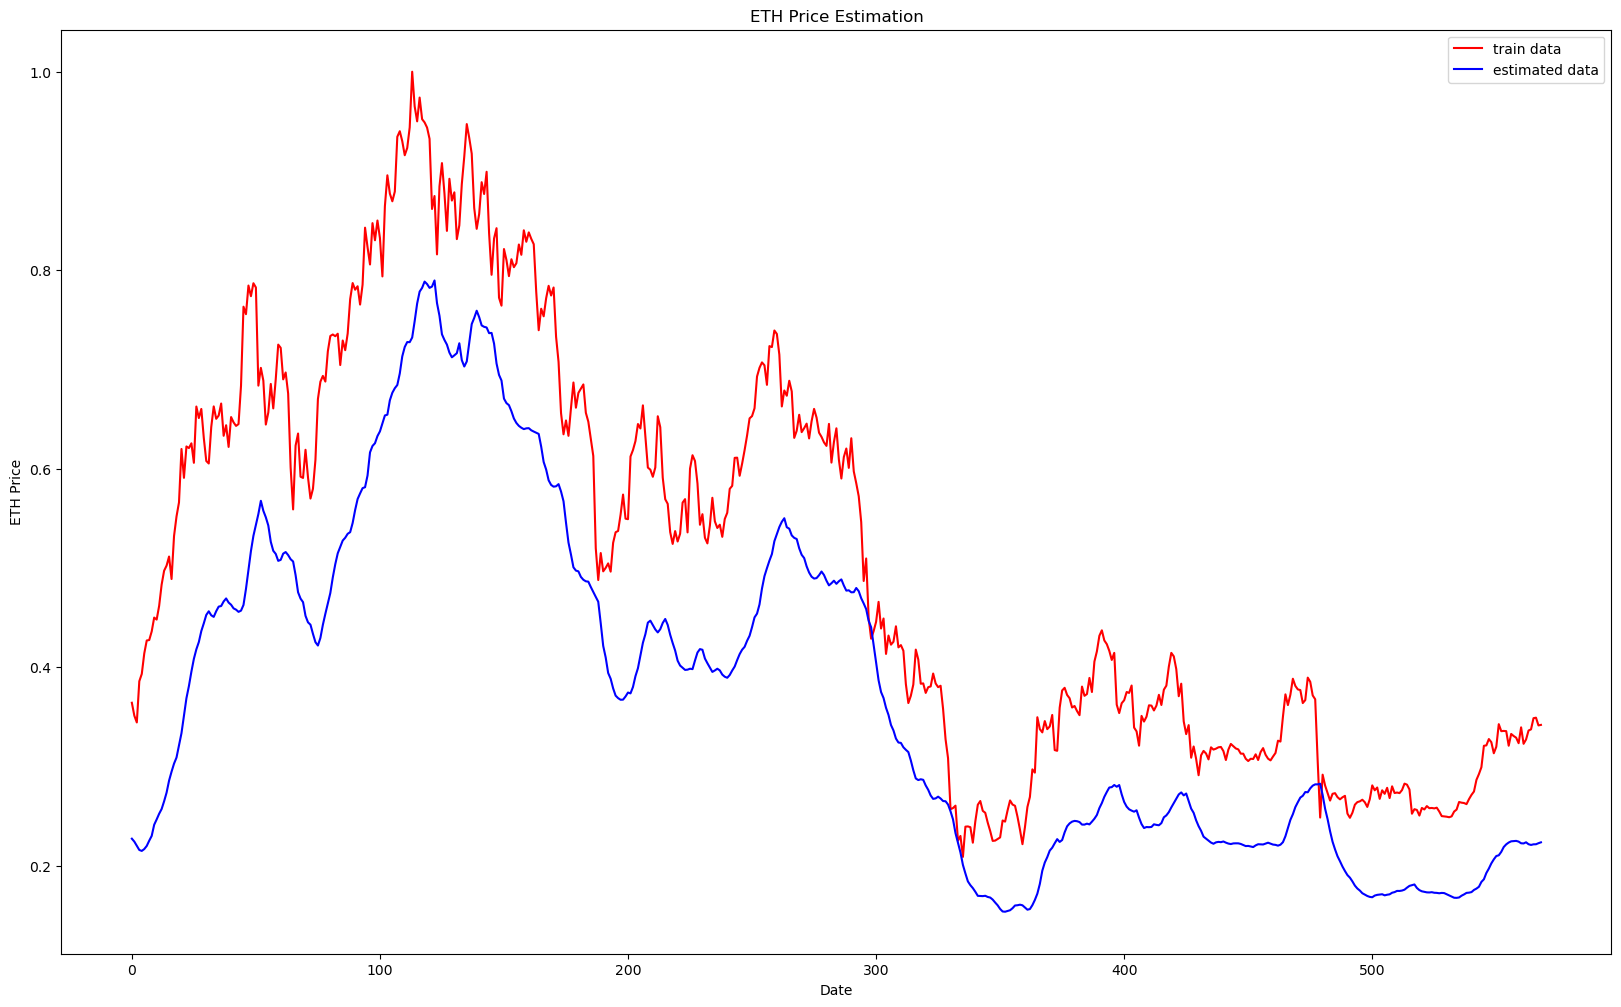

In [23]:
y_pred = model.predict(X_test)
plt.figure(figsize=(20,12))
plt.plot(y_test, color='red', label='train data')
plt.plot(y_pred, color='blue', label='estimated data')
plt.title('ETH Price Estimation')
plt.xlabel('Date')
plt.ylabel('ETH Price')
plt.legend()
plt.show()

In [24]:
last_estimated_price = (df.Close[-1] * y_pred[-1]) / y[-1]
last_real_price = df.Close[-1]
a = last_estimated_price - last_real_price
print("2023-02-06 예상 ETH 가격 :", last_estimated_price, 'KRW')
print("2023-02-06 실제 ETH 가격 :", last_real_price, 'KRW')
print("차이 : ", a)

2023-02-06 예상 ETH 가격 : [1333556.8] KRW
2023-02-06 실제 ETH 가격 : 2038984.625 KRW
차이 :  [-705427.9]


### 2-4. 미국 3대지수를 추가하니 더 못맞추는 것 같다!

### 3. 일별 가격 보다는 일별 가격 변화량으로 확인하는게 좋다고 함

In [32]:
df_change = df.copy()
df_change['Close'] = df_change['Close'].pct_change() # 변화량으로 바꿔주기
df_change.fillna(0, inplace=True)
df_change.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-11,334377.50000,357745.84375,333936.250,0.000000,352401.81250,943267611911
2017-11-12,352411.90625,357409.87500,334295.750,-0.022825,344358.12500,1804483690823
2017-11-13,343370.62500,368120.37500,343868.000,0.029599,354550.90625,1166354161489
2017-11-14,354603.50000,380059.34375,354742.875,0.062561,376732.06250,1193559640799
2017-11-15,377103.59375,379043.00000,364248.750,-0.021322,368699.50000,799283031624


In [33]:
## 데이터 정규화 (MaxAbsScaler)
df_change.sort_index(ascending=False).reset_index(drop=True)

scaler = MaxAbsScaler()
scale_cols = ['Open', 'High', 'Low', 'Volume', 'Close']
df_change_scaled = scaler.fit_transform(df_change[scale_cols])
df_scaled = pd.DataFrame(df_change_scaled)
df_scaled.columns = scale_cols

df_scaled = df_scaled.to_numpy()
X = df_scaled[:,:-1] # Open, High, Low, Volume
y = df_scaled[:,-1] # Close

data_X, data_y = [], []
for i in range(len(y) - WINDOW_SIZE):
    _X = X[i: i + WINDOW_SIZE]
    _y = y[i + WINDOW_SIZE]
    data_X.append(_X)
    data_y.append(_y)
data_X = np.array(data_X)
data_y = np.array(data_y)

X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.3, shuffle=False) # 시계열 데이터 이기 대문에 shuffle=False
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1325, 20, 4) (1325,)
(569, 20, 4) (569,)


In [34]:
model = Sequential(name = 'eth_change')
model.add(LSTM(20, input_shape=(WINDOW_SIZE, len(data_X[0][0])), activation='relu', return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1))

model.summary()

Model: "eth_change"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 20)                2000      
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,021
Trainable params: 2,021
Non-trainable params: 0
_________________________________________________________________


In [35]:
## 컴파일
model.compile(loss='mse', optimizer='adam', metrics='acc')

In [36]:
model_path = './model/eth_change-{epoch:2d}-{val_loss:.4f}.hdf5'
checkpoint = ModelCheckpoint(filepath=model_path, verbose=1, save_best_only=True)
earlystop = EarlyStopping(patience=10)
history = model.fit(X_train, y_train, epochs=200, batch_size=10, validation_split=0.3, callbacks=[checkpoint, earlystop])

Epoch 1/200
92/93 [============================>.] - ETA: 0s - loss: 0.0154 - acc: 0.0000e+00
Epoch 1: val_loss improved from inf to 0.01829, saving model to ./model\eth_change- 1-0.0183.hdf5
93/93 [==============================] - 2s 7ms/step - loss: 0.0159 - acc: 0.0000e+00 - val_loss: 0.0183 - val_acc: 0.0000e+00
Epoch 2/200
89/93 [===========================>..] - ETA: 0s - loss: 0.0163 - acc: 0.0000e+00
Epoch 2: val_loss improved from 0.01829 to 0.01737, saving model to ./model\eth_change- 2-0.0174.hdf5
93/93 [==============================] - 0s 5ms/step - loss: 0.0159 - acc: 0.0000e+00 - val_loss: 0.0174 - val_acc: 0.0000e+00
Epoch 3/200
91/93 [============================>.] - ETA: 0s - loss: 0.0162 - acc: 0.0000e+00
Epoch 3: val_loss improved from 0.01737 to 0.01681, saving model to ./model\eth_change- 3-0.0168.hdf5
93/93 [==============================] - 0s 5ms/step - loss: 0.0161 - acc: 0.0000e+00 - val_loss: 0.0168 - val_acc: 0.0000e+00
Epoch 4/200
83/93 [================

18/18 [==============================] - 0s 2ms/step


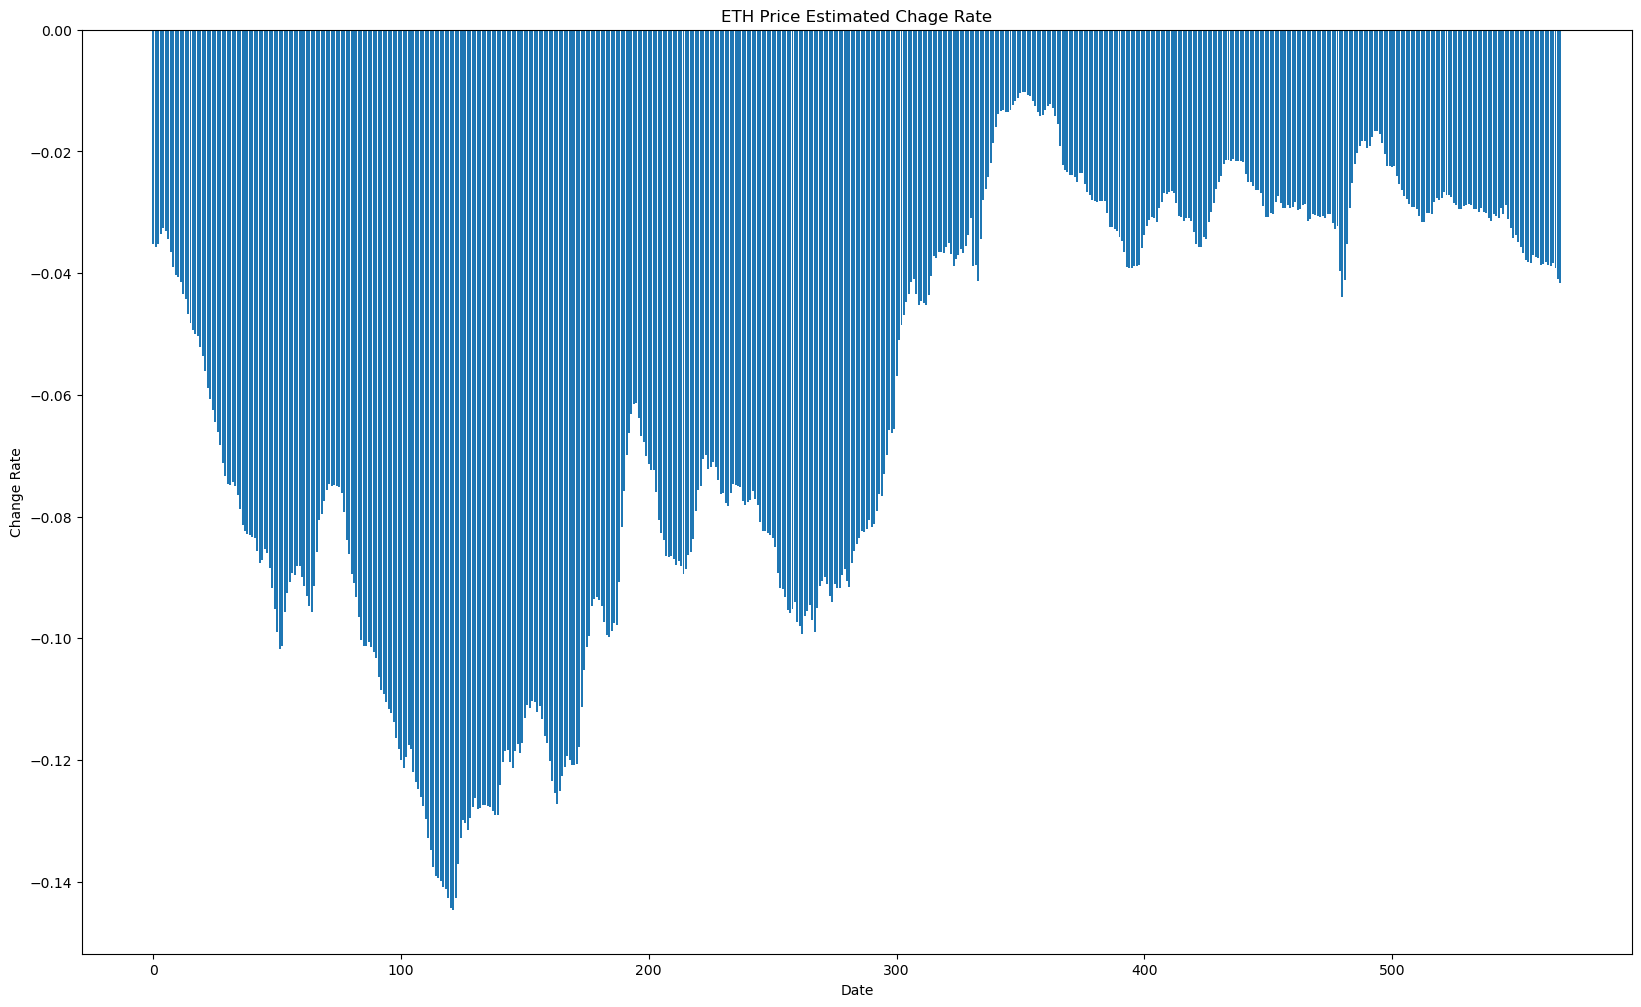

In [37]:
y_pred = model.predict(X_test)
plt.figure(figsize=(20,12))

bar_x, bar_y = [], []
for i in range(len(y_pred)):
    bar_x.append(i)
bar_y = np.concatenate(y_pred).tolist()
plt.bar(bar_x, bar_y)
plt.title('ETH Price Estimated Chage Rate')
plt.xlabel('Date')
plt.ylabel('Change Rate')
plt.show()

### 뭔가 잘못한듯 하지만 여기까지 인걸로 . . . :)